# Example 2.3: PO-SF-SM-RG
Pull-out of a short fiber from short matrix 

@author: rosoba

## Idealization of the pull-out problem
This notebook explains the derivation of the pullout model and provides also its executable form.
The one-dimensional idealization of the pull-out is introduced in the figure

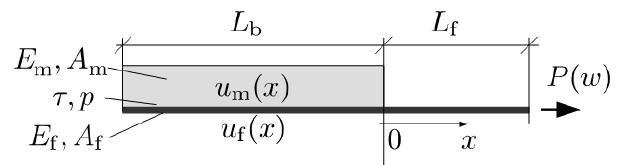

**Remark**: The origin of the coordinate system is placed at the transition between the bond zone and free zone of the fiber. The domain in the bond zone is defined as $x \in (-L_\mathrm{b},0)$. As a result, in the bond domain $x < 0$. The fiber is assumed to have an infinite length for $x < -L_\mathrm{b}$. This means that the length of the bond zone $L_\mathrm{b}$ remains constant - this fiber will never be pulled out.

The meaning of the variables defining the idealization is summarized in the table

In [1]:
%matplotlib notebook
import sympy as sp # symbolic algebra package
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
sp.init_printing() # enable nice formating of the derived expressions
import bmcs_pullout_ui as poui

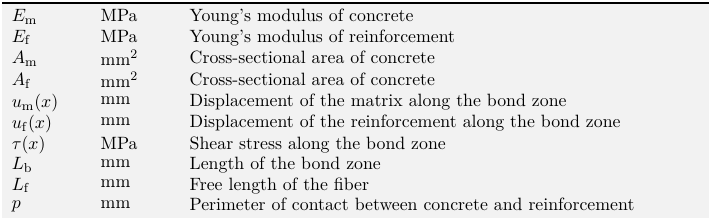

Here we tell `sympy` to remember these variables for further use. The parameter of the `symbols( str )` is a string that contains comma-separated printable symbol definition. One can use latex commands in this string to introduce e.g. Greek symbols like `\gamma, \beta`, etc. The number of symbols in `str` must be equal to the number of variables assigned on the left hand side of the `=` sign

In [2]:
E_f, A_f = sp.symbols(r'E_\mathrm{f}, A_\mathrm{f}', nonnegative = True )
E_m, A_m = sp.symbols(r'E_\mathrm{m}, A_\mathrm{m}', nonnegative = True )
tau, p = sp.symbols(r'\bar{\tau}, p', nonnegative = True)
P, w = sp.symbols('P, w')
x, a, L_b = sp.symbols('x, a, L_b')

In [3]:
py_vars = ('w', 'tau', 'p', 'L_b', 'A_f', 'A_m', 'E_f', 'E_m')
map_py2sp = {py_var : globals()[py_var] for py_var in py_vars}
sp_vars = tuple(map_py2sp[py_var] for py_var in py_vars)
sp_vars

## Reuse the pullout equation
As long as the debonding did not reach the end of the fiber, everything remains the sam

In [4]:
Pw_pull = sp.sqrt(2*w*tau*E_f*A_f*p)
Pw_pull

## Introduce finite embedded length
What happens if the debonded  length $a$ reaches the end of the bond zone $x = -L_\mathrm{b}$?
With reference to the blue subplot above, we see that this point corresponds to a maximum possible shear flow area over the bond zone. Thus, the maximum force that can be transfered through the bond is 
\begin{align}
 P_\max = \int_{x = -L_\mathrm{b}}^{x=} p \tau(x) \; \mathrm{d}x = p \bar{\tau} L_\mathrm{b}
\end{align}
The corresponding pullout displacement can be obtained by solving the equation
\begin{align}
P_\max = p \bar{\tau} L_\mathrm{b} = P_\mathrm{pull}(w) \implies w
\end{align}

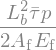

In [5]:
P_max = p * tau * L_b
w_argmax = sp.solve(P_max - Pw_pull, w)[0]
w_argmax

## Introduce finite fiber length
What happens when the fiber has a length $L_\mathrm{f} < L_\mathrm{b}$? The debonding phase with ascending pull-out curve remains the same as in the previous example. 

In [6]:
Pw_up_pull = Pw_pull


Once $a = L_\mathrm{b}$ the bond zone starts to shorten. 
The amount of shortening is equal to the slip at the unloaded end. Let us denote the diminishing effective length of the bond zone in the second phase  
\begin{align}
  b = -L_\mathrm{b} + u_\mathrm{f}(-L_b)
\end{align}
\begin{align}
 P_{\mathrm{down}} = p \bar{\tau} b
\end{align}

In [7]:
b, P_down = sp.symbols(r'b, P_\mathrm{down}')

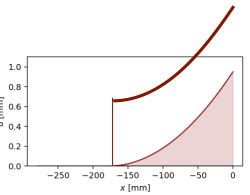
The strain at $x = b$ must be zero and the displacement must be equal to $L_\mathrm{b} - b$. Thus following the same arguments as above we can directly write
\begin{align}
 w = u_\mathrm{f}(-L_\mathrm{b}) - \frac{1}{2} \varepsilon_\mathrm{f}(0) b   
\end{align}
After substituting
\begin{align}
w = L_\mathrm{b} + b - \frac{1}{2} \varepsilon_\mathrm{f}(0) b
\end{align}

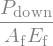

In [8]:
sig_down = P_down / A_f
eps_down = 1 / E_f * sig_down
eps_down

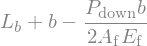

In [9]:
w_down =  (L_b + b) - sp.Rational(1,2) * eps_down * b
w_down

In [10]:
Pw_down_pull, Pw_down_push = sp.solve(w_down.subs(b, -P_down / p / tau) -w, P_down)
Pw_down_pull

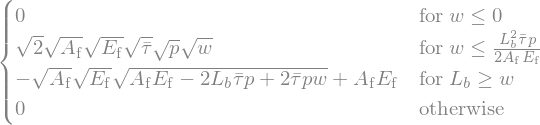

In [11]:
Pw_short = sp.Piecewise((0, w <= 0),
                        (Pw_up_pull, w <= w_argmax),
                        (Pw_down_pull, w <= L_b),
                        (0, True)
                       )
Pw_short

In [12]:
get_Pw_short = sp.lambdify(sp_vars, Pw_short)

<IPython.core.display.Javascript object>


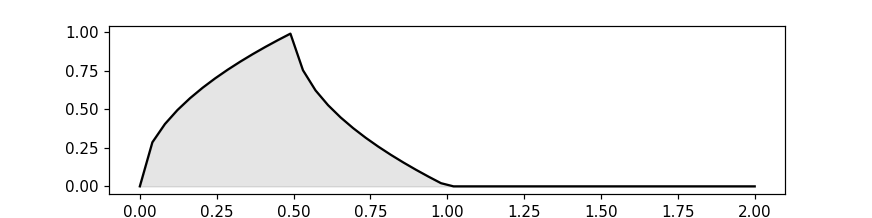

<string>:2: RuntimeWarning: invalid value encountered in sqrt


In [13]:
w_range = np.linspace(0,2,50)
params = {w: w_range, A_f:1, E_f:1, A_m:1, E_m:4, tau:1, p:1, L_b:1}
param_vals = tuple(params[map_py2sp[py_var]] for py_var in py_vars)
fix, ax = plt.subplots(1,1, figsize=(8,2))
poui.plot_filled_var(ax, w_range, get_Pw_short(*param_vals));

## Postprocessing 

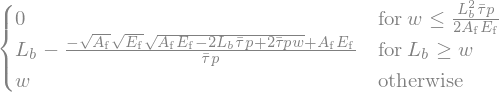

In [14]:
w_L_b_a = L_b - Pw_down_pull / p / tau
w_L_b = sp.Piecewise((0, w <= w_argmax),
                     (w_L_b_a, (w > w_argmax) & (w <= L_b)),
                     (w, True)) 
w_L_b

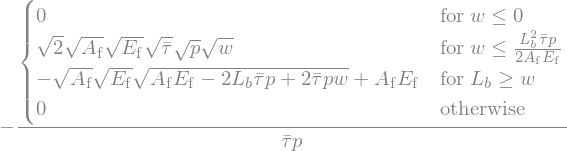

In [15]:
aw_pull_elastic = - (Pw_short / p / tau)
aw_pull_elastic

In [16]:
import traits.api as tr

class PO_SF_M_RG(tr.HasTraits):

    get_Pw_pull = sp.lambdify(sp_vars, Pw_short)
    get_w_L_b = sp.lambdify(sp_vars, w_L_b)
    get_aw_pull = sp.lambdify(sp_vars, aw_pull_elastic)
    

In [17]:
po = poui.ModelInteract(
    models=[PO_SF_M_RG],
    py_vars=list(py_vars),
    map_py2sp=map_py2sp
)

<IPython.core.display.Javascript object>


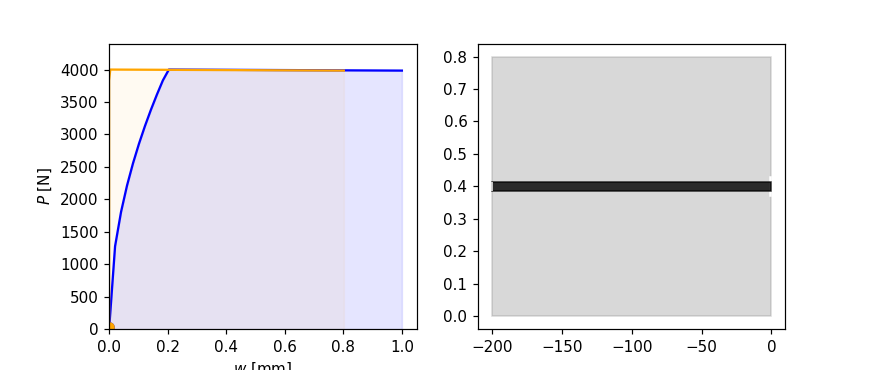

In [18]:
po.interact_geometry()

In [19]:
ds = 0.2
po_paper = poui.ModelInteract(
    models=[PO_SF_M_RG],
    py_vars=list(py_vars),
    map_py2sp=map_py2sp,
    w=.1, A_f=np.pi*(ds/2)**2, 
    E_f=200000, L_b=9.75, p=np.pi*ds, tau=6.56
)

<IPython.core.display.Javascript object>


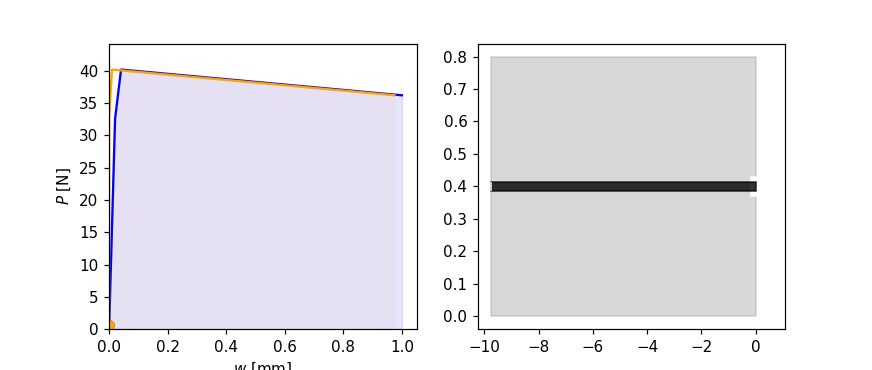

In [20]:
po_paper.interact_geometry()

## Task: use the parameters of the test to fit the response
Assume the length of the bond zone $L_b = 6.5m$ and $L_b = 9.75$, $E_\mathrm{f}=200000$ MPa and the diameter $d = 0.2$ mm. Identify the bond stress $\bar{\tau}$ rendering the pullout curve with the maximum force $P_\max$ = 49 N and final pullout displacement with zero force of 10 mm. 